In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.8, style="ticks")

subtype="h1n1"

start_year=2012
month="02"

seq_threshold = 0.4

In [2]:
our_model_name="VaxSeer"

year2result = dict()
for year in range(start_year, 2022):
    vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
    if not os.path.exists(vaccine_scores_path):
        continue
    for file in os.listdir(vaccine_scores_path):
        if file == "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
            if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                year2result[year] = our_model


predicted_results = []
for year in range(start_year, 2022):
    vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % \
                                (year, month, subtype, year-3, month, year, month, year-3, month, year, month)
    if not os.path.exists(vaccine_scores_path):
        continue
    for file in os.listdir(vaccine_scores_path):
        if file == "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
            if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                our_model["year"] = [year] * len(our_model)
                predicted_results.append(our_model)

predicted_results = pd.concat(predicted_results)
    
print(list(year2result.keys()))

x, y, hue = [], [], []


for year in range(start_year, 2022):
    df = predicted_results[predicted_results["year"] == year]
    df = df[df["coverage_seq"] > seq_threshold]
    row_best = np.argmin(df["score"].to_numpy())
    chosen_gt_score = df["gt_score_seq"].to_numpy()[row_best]
    best_gt_score = df["gt_score_seq"].to_numpy().min()
    
    x.append(year)
    y.append(-best_gt_score)
    hue.append("Best")
    
    x.append(year + 0.1)
    y.append(-chosen_gt_score)
    hue.append(our_model_name)


for year in range(start_year, 2022):
    score = year2result[year]["gt_score_seq"]
    score = score[~np.isnan(score)]
    coverage = year2result[year]["coverage_seq"]
    score = score[coverage > seq_threshold]
    score = np.median(score)
    x.append(year - 0.1)
    y.append(-score)
    hue.append("WHO")

predicted_results["neg_score"] = -predicted_results["score"]


[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


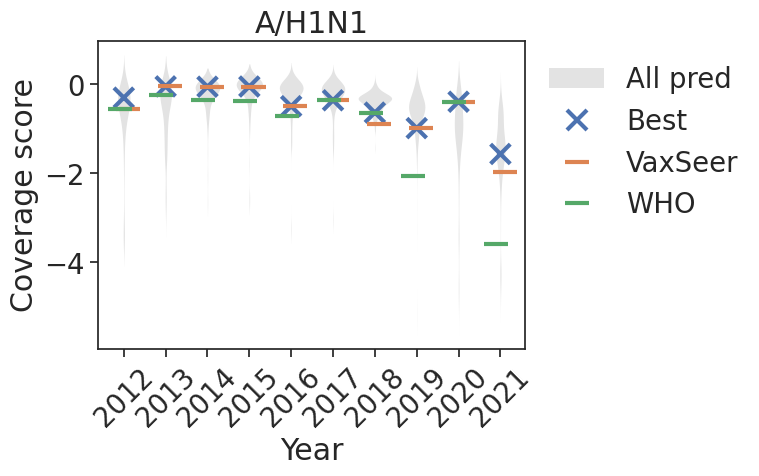

In [3]:
predicted_results["Nothing"] = ["All pred"] * len(predicted_results)


fig, ax = plt.subplots(figsize=(5.5, 4))


ax = sns.violinplot(data=predicted_results, x="year", y="neg_score", inner=None,
                palette="blend:#E3E3E3,#E3E3E3",
                saturation=0.5,
               linewidth=0, hue="Nothing", ax=ax)

marker_map = {"WHO": "o", "Best": "^", our_model_name: "o"}

marker=[marker_map[x] for x in hue]

x = np.asarray(x)
y = np.asarray(y)
hue = np.asarray(hue)

ax = sns.scatterplot(x=x - start_year, y=y, 
                     hue=hue, 
                     size=hue, sizes={"WHO": 300, "Best": 200, our_model_name: 300},
                    markers={"WHO": '_', "Best": 'x', our_model_name: '_'}, style=hue, ax=ax,
                     linewidth = 3, color="black"
                    )

    
ax.legend(frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Year") # , weight="bold"
ax.set_ylabel("Coverage score") # , weight="bold"
ax.set_title("A/%s" % subtype.upper()) # , weight="bold"

plt.xticks(rotation=45)

plt.savefig("figs/decision_%s_from_%d_boxplot.pdf" % (subtype, start_year), format='pdf', bbox_inches='tight')
